In [10]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from cnn_finetune import make_model
from sklearn.metrics import confusion_matrix

In [2]:
def create_data(root,sample_num=0):
# root = "./train/"
# sample_num = 3000
    face_files = os.listdir(root)
    df_face_all = []
    for face in face_files:
        cur_path = "%s/%s"%(root,face)
        f_name = os.listdir(cur_path)
        if sample_num != 0:
            f_name = f_name[:sample_num]
        f_name = ["%s/%s"%(cur_path,f) for f in f_name]
        df_face = pd.DataFrame()
        df_face['pic_name'] = f_name
        df_face['label'] = face
        df_face_all.append(df_face)
    df_face_all = pd.concat(df_face_all)
    return df_face_all


train = create_data("./train/")
val = create_data("./valid/")
test = create_data("./test/")
train.head()

,pic_name,label
0,./train//disgust/45850Exp1heartbroken_worker_4...,disgust
1,./train//disgust/28581Exp1crying_people_726.jpg,disgust
2,./train//disgust/47403Exp1amazed_people_405.jpg,disgust
3,./train//disgust/31850Exp1disgust_actor_506.jpg,disgust
4,./train//disgust/31249Exp1boring_grandmother_1...,disgust


In [3]:
lable_map =  {'disgust': 0,
 'angry': 0,
 'neutral': 1,
 'surprise': 2,
 'fear': 0,
 'sad': 0,
 'happy': 2}


train['label'] = train['label'].map(lable_map)
val['label'] = val['label'].map(lable_map)
test['label'] = test['label'].map(lable_map)

In [4]:
num_classes = 3
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
#图片增强器设置
transform_train = transforms.Compose([
    transforms.Resize(48),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# model = ConvNet(num_classes).to(device)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    
    

model = ResNet(ResidualBlock, [2, 2, 2],3).to(device)
model

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [12]:
class facedataset(torch.utils.data.Dataset):
    def __init__(self,df,transform=None):
        self.imgs = df['pic_name'].tolist()
        self.labels = df['label'].tolist()
        self.transform = transform
    def __len__(self):
        #返回数据总个数
        return len(self.imgs)
    def __getitem__(self,idx):
        #获取对应的图片名称
        data=self.imgs[idx]
        #获取对应的label
        label = self.labels[idx]
        #读取图片
        img = Image.open(data).convert('RGB')
        

        
        #图皮增强器如果不为空,就进行增强
        if self.transform is not None:
            img = self.transform(img)
        return img,label
    
    
    

#https://zhuanlan.zhihu.com/p/73558315
def plot_confusion_matrix(cm, mark=''):
    title = "%s Confusion Matrix"%(mark)
    classes = list(range(3))
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=3)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
 
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.GnBu
#                cmap=plt.cm.binary
              )
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
#     plt.savefig(savename, format='png')
    plt.show()
    



def get_metric_acc(y, pre_y,mark):
  
    cm = confusion_matrix(y, pre_y)
    
    plot_confusion_matrix(cm,mark)
    


In [6]:
#设置epoch
num_epochs = 5
#设置学习率
learning_rate = 0.001
# curr_lr = 0.001
#设置随机性
torch.manual_seed(111)

#数据集对象
train_data = facedataset(train, transform=transform_train)

val_data = facedataset(val, transform=transform_train)

test_data = facedataset(test, transform=transform_train)



train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=True)






total_step = len(train_loader)
# Loss and optimizer
#设置损失函数
criterion = nn.CrossEntropyLoss().to(device)
#设置优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:


for epoch in range(num_epochs):
    print("%s epoch"%(epoch))
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 20 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Decay learning rate
#     if (epoch + 1) % 20 == 0:
#         learning_rate /= 3
#         update_lr(optimizer, curr_lr)

0 epoch
Epoch [1/5], Step [20/2906] Loss: 1.0375
Epoch [1/5], Step [40/2906] Loss: 1.0733
Epoch [1/5], Step [60/2906] Loss: 1.0401
Epoch [1/5], Step [80/2906] Loss: 1.0201
Epoch [1/5], Step [100/2906] Loss: 1.0620
Epoch [1/5], Step [120/2906] Loss: 1.0508
Epoch [1/5], Step [140/2906] Loss: 1.0784
Epoch [1/5], Step [160/2906] Loss: 1.0556
Epoch [1/5], Step [180/2906] Loss: 1.0146
Epoch [1/5], Step [200/2906] Loss: 1.0512
Epoch [1/5], Step [220/2906] Loss: 1.0197
Epoch [1/5], Step [240/2906] Loss: 1.1418
Epoch [1/5], Step [260/2906] Loss: 1.1080
Epoch [1/5], Step [280/2906] Loss: 1.0530
Epoch [1/5], Step [300/2906] Loss: 1.0486
Epoch [1/5], Step [320/2906] Loss: 1.0718
Epoch [1/5], Step [340/2906] Loss: 1.0837
Epoch [1/5], Step [360/2906] Loss: 1.0618
Epoch [1/5], Step [380/2906] Loss: 0.9513
Epoch [1/5], Step [400/2906] Loss: 1.0629
Epoch [1/5], Step [420/2906] Loss: 0.9855
Epoch [1/5], Step [440/2906] Loss: 1.0487
Epoch [1/5], Step [460/2906] Loss: 1.1791
Epoch [1/5], Step [480/2906] L

Epoch [2/5], Step [980/2906] Loss: 0.8380
Epoch [2/5], Step [1000/2906] Loss: 0.6957
Epoch [2/5], Step [1020/2906] Loss: 0.6999
Epoch [2/5], Step [1040/2906] Loss: 0.8823
Epoch [2/5], Step [1060/2906] Loss: 0.5836
Epoch [2/5], Step [1080/2906] Loss: 0.7932
Epoch [2/5], Step [1100/2906] Loss: 0.4162
Epoch [2/5], Step [1120/2906] Loss: 0.6538
Epoch [2/5], Step [1140/2906] Loss: 0.7415
Epoch [2/5], Step [1160/2906] Loss: 0.7346
Epoch [2/5], Step [1180/2906] Loss: 0.6264
Epoch [2/5], Step [1200/2906] Loss: 0.5946
Epoch [2/5], Step [1220/2906] Loss: 0.9965
Epoch [2/5], Step [1240/2906] Loss: 0.6269
Epoch [2/5], Step [1260/2906] Loss: 0.7239
Epoch [2/5], Step [1280/2906] Loss: 0.8400
Epoch [2/5], Step [1300/2906] Loss: 0.5767
Epoch [2/5], Step [1320/2906] Loss: 0.6787
Epoch [2/5], Step [1340/2906] Loss: 0.9559
Epoch [2/5], Step [1360/2906] Loss: 0.8324
Epoch [2/5], Step [1380/2906] Loss: 0.7069
Epoch [2/5], Step [1400/2906] Loss: 0.8820
Epoch [2/5], Step [1420/2906] Loss: 0.5254
Epoch [2/5],

Epoch [3/5], Step [1920/2906] Loss: 0.5813
Epoch [3/5], Step [1940/2906] Loss: 0.8227
Epoch [3/5], Step [1960/2906] Loss: 0.4962
Epoch [3/5], Step [1980/2906] Loss: 0.5526
Epoch [3/5], Step [2000/2906] Loss: 0.6071
Epoch [3/5], Step [2020/2906] Loss: 1.0306
Epoch [3/5], Step [2040/2906] Loss: 0.7259
Epoch [3/5], Step [2060/2906] Loss: 0.5557
Epoch [3/5], Step [2080/2906] Loss: 0.8168
Epoch [3/5], Step [2100/2906] Loss: 0.7926
Epoch [3/5], Step [2120/2906] Loss: 0.6904
Epoch [3/5], Step [2140/2906] Loss: 0.8066
Epoch [3/5], Step [2160/2906] Loss: 0.5262
Epoch [3/5], Step [2180/2906] Loss: 0.7668
Epoch [3/5], Step [2200/2906] Loss: 0.5794
Epoch [3/5], Step [2220/2906] Loss: 0.8216
Epoch [3/5], Step [2240/2906] Loss: 0.4594
Epoch [3/5], Step [2260/2906] Loss: 0.9203
Epoch [3/5], Step [2280/2906] Loss: 0.6520
Epoch [3/5], Step [2300/2906] Loss: 0.7031
Epoch [3/5], Step [2320/2906] Loss: 0.6439
Epoch [3/5], Step [2340/2906] Loss: 0.7197
Epoch [3/5], Step [2360/2906] Loss: 0.6099
Epoch [3/5]

Epoch [4/5], Step [2860/2906] Loss: 0.5063
Epoch [4/5], Step [2880/2906] Loss: 0.6261
Epoch [4/5], Step [2900/2906] Loss: 0.6593
4 epoch
Epoch [5/5], Step [20/2906] Loss: 0.5435
Epoch [5/5], Step [40/2906] Loss: 0.5613
Epoch [5/5], Step [60/2906] Loss: 0.5435
Epoch [5/5], Step [80/2906] Loss: 0.5628
Epoch [5/5], Step [100/2906] Loss: 0.7443
Epoch [5/5], Step [120/2906] Loss: 0.7211
Epoch [5/5], Step [140/2906] Loss: 0.4535
Epoch [5/5], Step [160/2906] Loss: 0.5017
Epoch [5/5], Step [180/2906] Loss: 0.7098
Epoch [5/5], Step [200/2906] Loss: 0.4178
Epoch [5/5], Step [220/2906] Loss: 0.5234
Epoch [5/5], Step [240/2906] Loss: 0.5365
Epoch [5/5], Step [260/2906] Loss: 0.5219
Epoch [5/5], Step [280/2906] Loss: 0.5268
Epoch [5/5], Step [300/2906] Loss: 0.8465
Epoch [5/5], Step [320/2906] Loss: 0.5451
Epoch [5/5], Step [340/2906] Loss: 0.5929
Epoch [5/5], Step [360/2906] Loss: 0.6140
Epoch [5/5], Step [380/2906] Loss: 0.4876
Epoch [5/5], Step [400/2906] Loss: 0.6815
Epoch [5/5], Step [420/2906

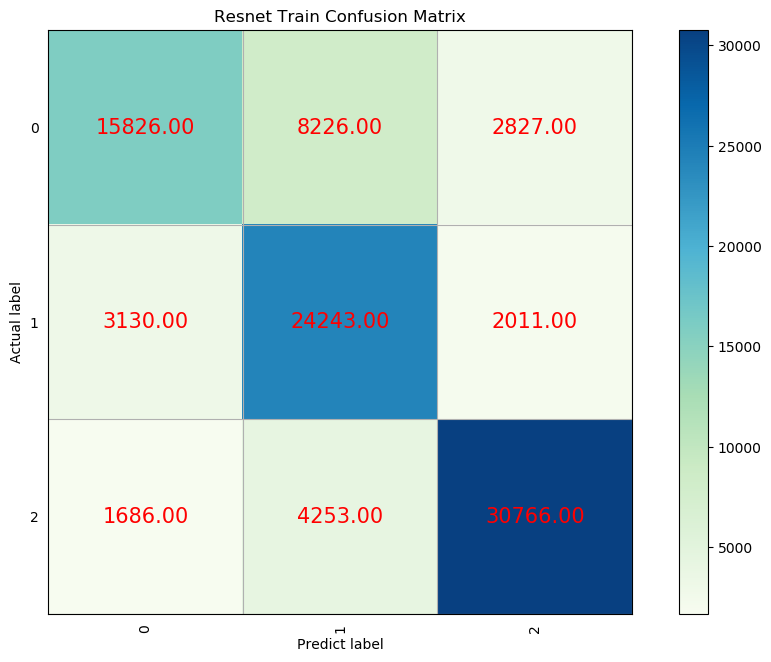

Accuracy of the model on the train images: 76.19288357284226 %


In [16]:
real_y = []
pre_y = []
model.eval()




with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        label_list = labels.cuda().data.cpu().numpy()
        real_y += label_list.tolist()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        pre_list = predicted.cuda().data.cpu().numpy()
        pre_y += pre_list.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
get_metric_acc(real_y,pre_y,'Resnet Train')
print('Accuracy of the model on the train images: {} %'.format(100 * correct / total))

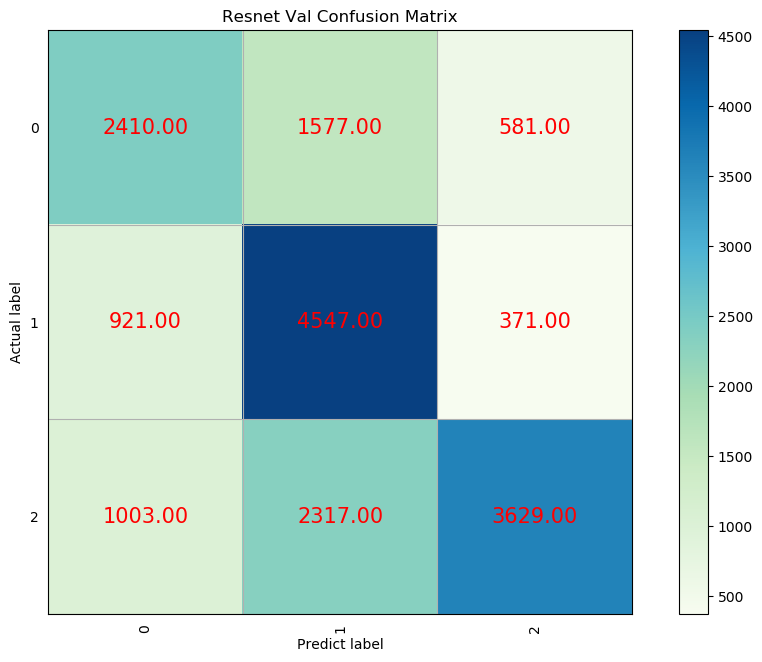

Accuracy of the model on the val images: 60.99331643235769 %


In [17]:
real_y = []
pre_y = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        label_list = labels.cuda().data.cpu().numpy()
        label_list = label_list.tolist()
        real_y += label_list
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        pre_list = predicted.cuda().data.cpu().numpy()
        pre_y += pre_list.tolist()
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
get_metric_acc(real_y,pre_y,'Resnet Val')
print('Accuracy of the model on the val images: {} %'.format(100 * correct / total))

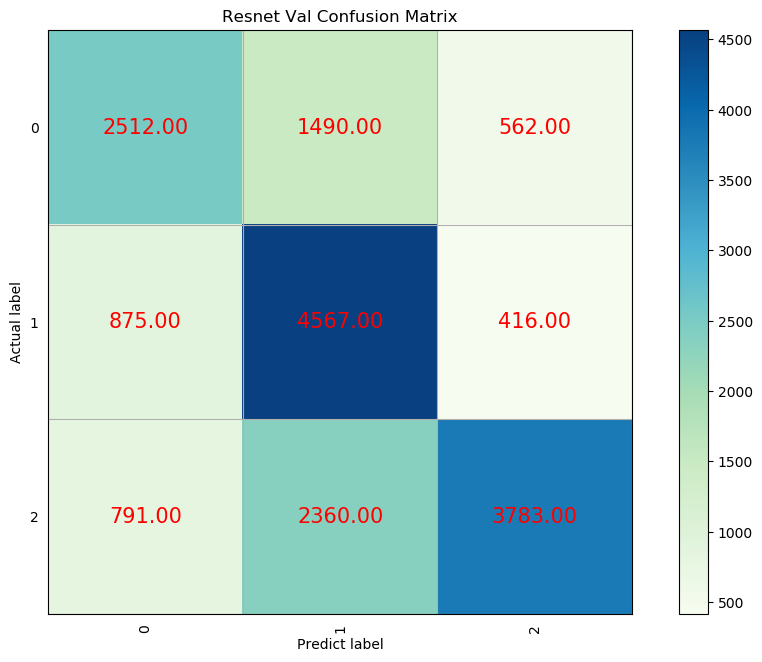

Accuracy of the model on the test images: 62.58354459552892 %


In [18]:
real_y = []
pre_y = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        label_list = labels.cuda().data.cpu().numpy()
        label_list = label_list.tolist()
        real_y += label_list
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        pre_list = predicted.cuda().data.cpu().numpy()
        pre_y += pre_list.tolist()
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
get_metric_acc(real_y,pre_y,'Resnet Val')
print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))